In [1]:
import nltk
nltk.download('punkt') 
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

import numpy as np
import pandas as pd
import sklearn
from tensorflow import keras   
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import one_hot

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
data = pd.read_excel('/content/Data set.xlsx')
X = data["Text"]
Y = data["Sentiment"]

In [3]:
import re
!pip install contractions
import contractions
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def tag_replace(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:         
        return None

def preprocess_data(sentence):
  # Lowercasing the senctences
  sentence = sentence.lower()

  # Urls and punctuation removal
  sentence = re.sub(r'^http\S+', '', sentence)
  sentence = re.sub(r"[,.;@#?!&$]+\ *", " ", sentence)
  
  # Replacing contracted words with expanded words
  sentence = contractions.fix(sentence)

  # Brackets and number removal
  sentence = re.sub("[^a-zA-Z]"," ", sentence)

  # Word tokenizarion
  words = word_tokenize(sentence)

  # stop words removal 
  words = [ word for word in words if word not in stop_words ]

  # Adding parts of speech to the words for better lemmatization
  pos_tagged_words = pos_tag(words)
  words = []
  for word, tag in pos_tagged_words:
    tag = tag_replace(tag)
    if tag is not None:
      words.append(lemmatizer.lemmatize(word, tag))
    else:
      words.append(word)
  return " ".join(words)


     |████████████████████████████████| 106 kB 4.0 MB/s 
     |████████████████████████████████| 287 kB 23.6 MB/s 


In [4]:
preprocessedX = []

for sentence in X:
  preprocessedX.append(preprocess_data(sentence))

X = np.array(preprocessedX)
Y = Y.map(lambda x: 1 if x =='POS' else 0)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


# Using tfidf vectorizer
vec = TfidfVectorizer(use_idf=True, min_df=2, max_features=5000)
tfidf_X = np.array(vec.fit_transform(X).todense())
X_train, X_test, y_train, y_test = train_test_split(tfidf_X, Y, test_size = 0.3, random_state = 42)

# Using count vectorizer
cvec = CountVectorizer(min_df=2, max_features=5000)
c_X = np.array(cvec.fit_transform(X).todense())
c_X_train, c_X_test, c_y_train, c_y_test = train_test_split(c_X, Y, test_size = 0.3, random_state = 42)

In [6]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from keras.layers import LSTM
from keras.layers import Embedding
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

In [7]:
def SVM(X_train,y_train,X_test):
  SVM = SVC()
  SVM.fit(X_train, y_train)
  predicted_SVM = SVM.predict(X_test)
  return predicted_SVM

In [8]:
def MNB(X_train,y_train,X_test):
  mnb = MultinomialNB()
  mnb.fit(X_train,y_train)
  predicted_MNB = mnb.predict(X_test)
  return predicted_MNB

In [9]:
def BNB(X_train,y_train,X_test):
  bnb = BernoulliNB()
  bnb.fit(X_train,y_train)
  predicted_BNB = bnb.predict(X_test)
  return predicted_BNB

In [10]:
def DTC(X_train,y_train,X_test):
  dtc = DecisionTreeClassifier()
  dtc.fit(X_train,y_train)
  predicted_DTC = dtc.predict(X_test)
  return predicted_DTC

In [11]:
def LR(X_train,y_train,X_test):
  lr = LogisticRegression(random_state=42)
  lr.fit(X_train, y_train)
  predicted_LR = lr.predict(X_test)
  return predicted_LR

In [12]:
def DENSE_NR(X_train,y_train, X_test): 
  nr = Sequential()
  
  nr.add(Dense(1024, activation='relu', input_shape=(X_train[0].shape[0],)))
  nr.add(Dropout(0.2))
  nr.add(Dense(128, activation='relu'))
  nr.add(Dropout(0.2))
  nr.add(Dense(24, activation='relu'))
  nr.add(Dense(4, activation='relu'))
  nr.add(Flatten())
  nr.add(Dense(1, activation='sigmoid'))
  
  nr.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
  nr.fit(X_train, y_train, batch_size = 10, epochs=20, verbose=0)
  
  predicted_NR = nr.predict(X_test)
  
  for i in range(len(predicted_NR)):
    if(predicted_NR[i] <= 0.5):
      predicted_NR[i] = 0
    else:
      predicted_NR[i] = 1

  return predicted_NR

In [13]:
from sklearn.metrics import mean_absolute_error
y_pred = DENSE_NR(X_train, y_train, X_test)
mae = mean_absolute_error(y_pred, y_test)


In [15]:
def LSTM_NR():
    oneHotX = []
    for sent in X:
      oneHotX.append(one_hot(sent, 10000))

    oneHotX = np.array(oneHotX)
    oneHotX = pad_sequences(oneHotX , maxlen = 50)

    X_train, X_test, y_train, y_test = train_test_split(oneHotX, Y, test_size = 0.3, random_state = 42)
  
    model = Sequential()
    model.add(Embedding(10000, 40,input_length = oneHotX.shape[1]))
    model.add(LSTM(32))
  
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    model.fit(X_train, y_train.to_numpy(), batch_size = 10, epochs=2, verbose=0)
    predicted_NR = model.predict(X_test)
    
    for i in range(len(predicted_NR)):
      if(predicted_NR[i] <= 0.5):
        predicted_NR[i] = 0
      else:
        predicted_NR[i] = 1
    return y_test,predicted_NR

In [16]:
from sklearn.metrics import confusion_matrix

classifiers = [SVM, MNB, BNB, DTC, LR,DENSE_NR]

def getConMat(y_pred, y_test):
  M = confusion_matrix(y_test, y_pred)
  tn, fp, fn, tp = M.ravel() 
  acc = (tn+tp)/(tn+tp+fn+fp)
  pr = tp/(tp+fp)
  rec = tp/(tp+fn)
  f1score = 2*pr*rec/(pr+rec)
  return acc, pr, rec, f1score

# Classification using tfidf scores
def classify(X_train,y_train, X_test, y_test):
  accuracy = []
  precision = []
  recall = []
  f1scores = []
  for classifier in classifiers:
    y_pred = classifier(X_train, y_train, X_test)
  
    acc, pr, rec, f1 = getConMat(y_pred, y_test)
    accuracy.append(acc)
    precision.append(pr)
    recall.append(rec)
    f1scores.append(f1)

  return accuracy, precision ,recall ,f1scores

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

classifierLabels = ['SVM', 'MultinomialNB', 'BernoulliNB', 'Decision tree', 'Maximum entropy' ,'Dense_NR']
  
def showf1scores(f1scores, c_f1scores):
  plt.plot(classifierLabels ,f1scores)
  plt.plot(classifierLabels ,c_f1scores)
  plt.legend(["TF-IDF","Count vectors"])
  plt.xlabel("Different classifiers")
  plt.ylabel("F1 scores")
  plt.show()

def show_graphs(accuracy, recall, precision,vec):
  barWidth = 0.25
  fig = plt.subplots(figsize =(12, 8))
  
  br1 = np.arange(len(accuracy))
  br2 = [x + barWidth for x in br1]
  br3 = [x + barWidth for x in br2]
  
  # Make the plot
  plt.bar(br1, accuracy, color ='r', width = barWidth,
          edgecolor ='grey', label ='Accuracy')
  plt.bar(br2, recall, color ='g', width = barWidth,
          edgecolor ='grey', label ='Recall')
  plt.bar(br3, precision, color ='b', width = barWidth,
          edgecolor ='grey', label ='Precision')
  
  # Adding Xticks
  plt.xticks([r + barWidth for r in range(len(accuracy))],classifierLabels)
  plt.title(vec)
  
  plt.legend()
  plt.show()  


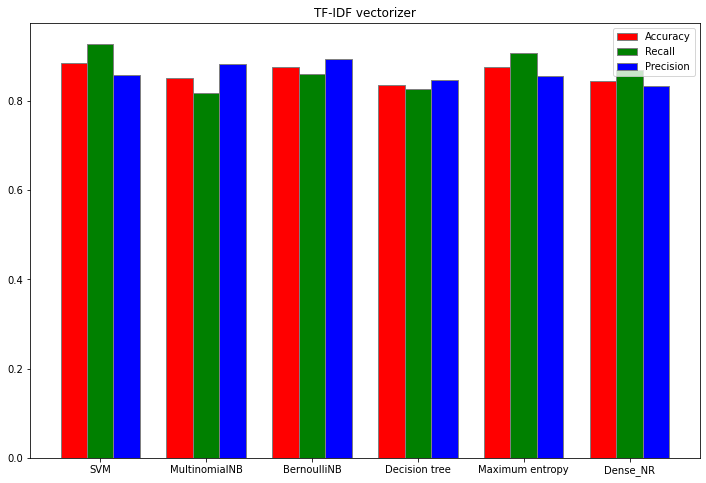

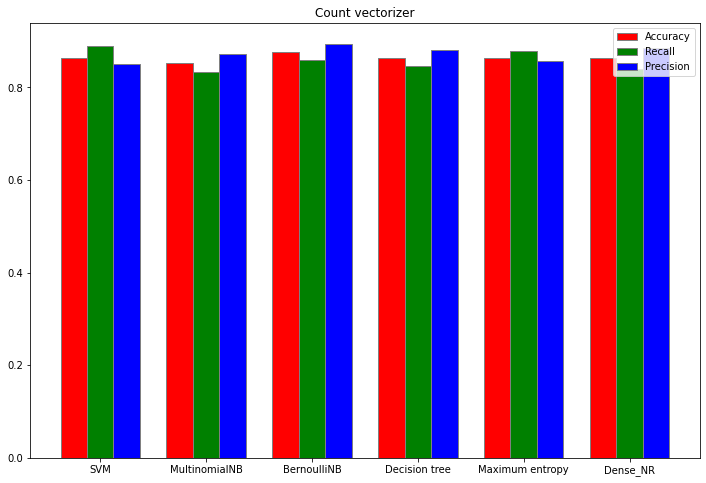

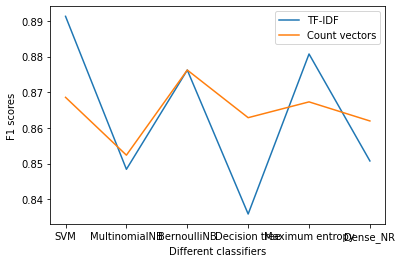

In [24]:
accuracy, precision ,recall ,f1scores = classify(X_train, y_train, X_test, y_test)
c_accuracy, c_precision ,c_recall ,c_f1scores = classify(c_X_train, c_y_train, c_X_test, c_y_test)


show_graphs(accuracy, recall, precision,"TF-IDF vectorizer")
show_graphs(c_accuracy, c_recall, c_precision,"Count vectorizer")
showf1scores(f1scores, c_f1scores)


In [25]:
from tabulate import tabulate

def make_table(a,b):
  tf_idf = ["TF_IDF vec"]
  count = ["Count vec"]
  typevec = ["Type of vectorizer"]
  tf_idf.extend(a)
  count.extend(b)
  data = [tf_idf, count]
  typevec.extend(classifierLabels)
  print(tabulate(data, headers=typevec, tablefmt="fancy_grid"))

print("Accuracy")
make_table(accuracy, c_accuracy)
print("Recall")
make_table(recall, c_recall)
print("Precision")
make_table(precision, c_precision)
print("F1 scores")
make_table(f1scores, c_f1scores)

Accuracy
╒══════════════════════╤══════════╤═════════════════╤═══════════════╤═════════════════╤═══════════════════╤════════════╕
│ Type of vectorizer   │      SVM │   MultinomialNB │   BernoulliNB │   Decision tree │   Maximum entropy │   Dense_NR │
╞══════════════════════╪══════════╪═════════════════╪═══════════════╪═════════════════╪═══════════════════╪════════════╡
│ TF_IDF vec           │ 0.885    │        0.851667 │      0.876667 │        0.835    │          0.875    │   0.845    │
├──────────────────────┼──────────┼─────────────────┼───────────────┼─────────────────┼───────────────────┼────────────┤
│ Count vec            │ 0.863333 │        0.853333 │      0.876667 │        0.863333 │          0.863333 │   0.863333 │
╘══════════════════════╧══════════╧═════════════════╧═══════════════╧═════════════════╧═══════════════════╧════════════╛
Recall
╒══════════════════════╤══════════╤═════════════════╤═══════════════╤═════════════════╤═══════════════════╤════════════╕
│ Type of vector

In [26]:
LSTM_test, LSTM_pred = LSTM_NR()
acc, pr, rec, f1score = getConMat(LSTM_pred, LSTM_test)

data = [["Accuracy", acc, accuracy[0]],
        ["Precision", pr, precision[0]],
        ["Recall", rec, recall[0]],
        ["F1 scores", f1score, f1scores[0]]
      ]
headers = ["Classifiers", "SVM","LSTM"]

print(tabulate(data, headers=headers, tablefmt="fancy_grid"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


╒═══════════════╤══════════╤══════════╕
│ Classifiers   │      SVM │     LSTM │
╞═══════════════╪══════════╪══════════╡
│ Accuracy      │ 0.801667 │ 0.885    │
├───────────────┼──────────┼──────────┤
│ Precision     │ 0.773529 │ 0.857576 │
├───────────────┼──────────┼──────────┤
│ Recall        │ 0.862295 │ 0.927869 │
├───────────────┼──────────┼──────────┤
│ F1 scores     │ 0.815504 │ 0.891339 │
╘═══════════════╧══════════╧══════════╛
